In [1]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scripts.cell_model_general import *
import sksundae as sun
import pandas as pd
from scripts.batch_culture_simulation import *
import joblib
from pathlib import Path
import os
import time

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 14*24*60; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = ((10*cultvol)/180)*6.02e23; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [3]:
#topology
ctT         = 0; # TF_P control on TX of T
ctE         = 1; # TF_P control on TX of E
ctEprod     = 0; # TF_P control on TX of Ep
ctTF        = 0; # TF_P control on TF
ctEprotease = -1; # TF_P control on Eprotease
ctTprod     = 0; # TF_P control on TX of the engineered P transporter Tp

#functions within topology (0 = Mannan 2025 TX regulation model)
T_TXmodel         = 0
E_TXmodel         = 0
Eprod_TXmodel     = 0
TF_TXmodel        = 0
Eprotease_TXmodel = 0
Tprod_TXmodel     = 0

topology = [ctT, ctE, ctEprod, ctTF, ctEprotease, ctTprod, T_TXmodel, E_TXmodel, 
            Eprod_TXmodel, TF_TXmodel, Eprotease_TXmodel, Tprod_TXmodel]

creating the host and engineered parameter arrays

In [ ]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
    #    0   1     2      3       4         5        6        7           8
#xpPR = [w0, wE, wEprod, wTF, wEprotease, wTprod, k_Eprod, Km_Eprod, k_Eprotease, 
#            9            10       11     12    13    14         15         16
#        Km_Eprotease, k_Tprod, Km_Tprod, K_T, K_E, K_Eprod, K_Eprotease, K_Tprod, 
#        17      18      19       20     21   22
#        K_TF, kdiffP, VolCell, VolCult, ksf, ksr

xPR[2] = 0 #wEprod


Running the exact simulation

In [5]:
T , Y = batch_cult_sim(base_params, hPR, xPR, integration_method="BDF", plot=False, rtol=1E-6, atol=1E-9)

c:\Users\amabe_mapds4e\Documents\GitHub\essentiality_toxicity_circuit\scripts\cell_model_general.py:272: NumbaWarning: Cannot cache compiled function "BatchCultModel_DC" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  dY = BatchCultModel_DC(T, Y, hPR, xPR, SysTopol)
c:\Users\amabe_mapds4e\Documents\GitHub\essentiality_toxicity_circuit\scripts\cell_model_general.py:268: NumbaWarning: Cannot cache compiled function "BatchCultModel_SS" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True, fastmath=True)
c:\Users\amabe_mapds4e\Documents\GitHub\essentiality_toxicity_circuit\scripts\cell_model_general.py:272: NumbaWarning: Cannot cache compiled function "BatchCultModel_DC" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  dY = BatchCultModel_DC(T, Y, hPR, xPR, SysTopol)
c:\Users\amabe_mapds4e\Documents\GitHub\essentiality_toxicity_circuit\scripts\cell_model_general.py:268: NumbaWarning: Can

Plotting pre induction

Text(0, 0.5, 'External Product')

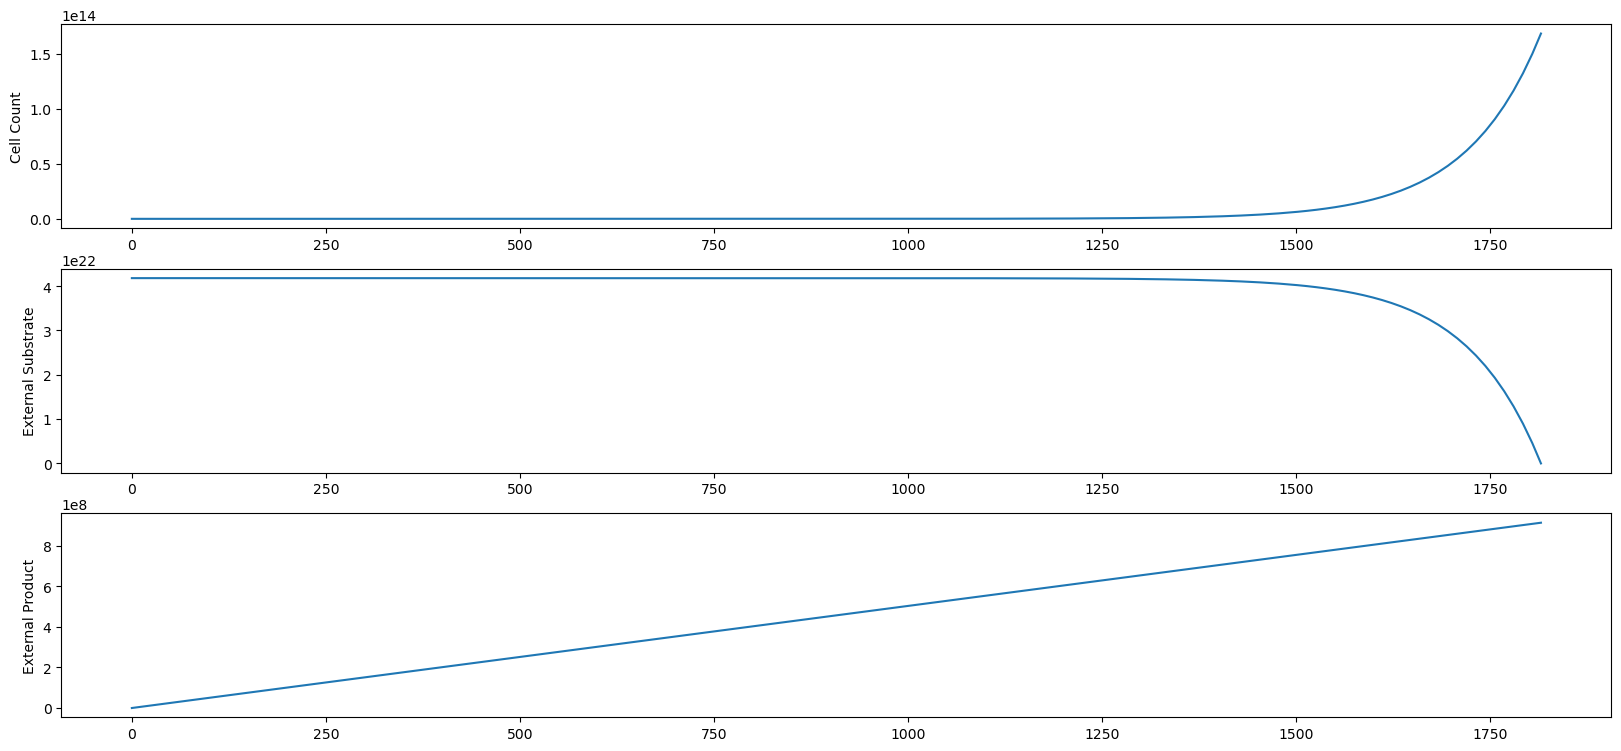

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(20, 9))
axs[0].plot(T, Y[0])
axs[0].set_ylabel("Cell Count")
axs[1].plot(T, Y[1])
axs[1].set_ylabel("External Substrate")
axs[2].plot(T, Y[2])
axs[2].set_ylabel("External Product")

Plotting the internal + external product over time

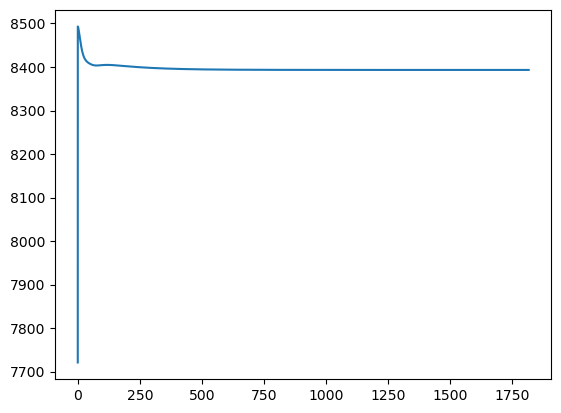

In [7]:
plt.plot(T, Y[25])

Plotting the transcription factor and its product dimer over time

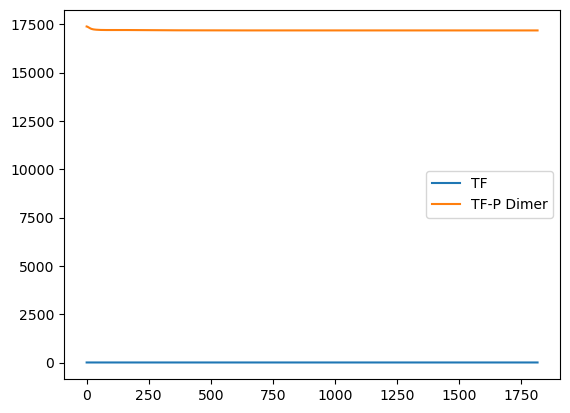

In [8]:
plt.plot(T, Y[28], label="TF")
plt.plot(T, Y[29], label="TF-P Dimer")
plt.legend()

Plotting E over time

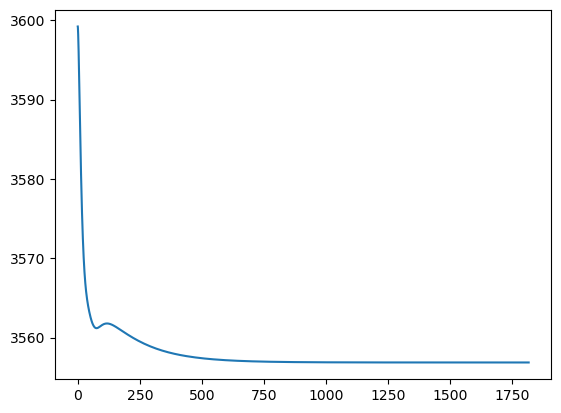

In [9]:
fig, ax = plt.subplots()
ax.plot(T, Y[10])
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

Plotting protease over time

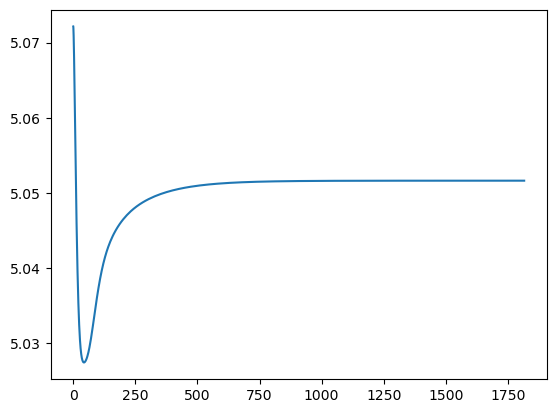

In [10]:
fig, ax = plt.subplots()
ax.plot(T, Y[32])
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

Comparing derivatives at the start, and at induction

In [11]:
y_init = Y_exact[:, 0]
y_tind = Y_exact[:, tind_idx]

print(lam_dsp_calc(y_init, hPR, xPR, topology))
print(calculate_ss_pre(xS0, xPR))

xPR_temp = xPR.copy()
xPR_temp[-2] = 1E23
print(lam_dsp_calc(y_tind, hPR, xPR, topology))
print(calculate_ss_post(Y_exact[1, tind_idx], xPR))

NameError: name 'Y_exact' is not defined